### NOW EXPERIMENTING:
Pinet: 
* check iou_metrix function
* try SGD, its noiser
* set higher w = 1.0, ramp up delay to 50, ramp up peroid to 50, only sample 3600 test dataset
* change core model

### Done:
* regularized by pseudo labeled data, but it also have some lagecy label which seems in the eraly stage, seems wrong
* try pure training dataset, should be same to normal train
* noise and rotation cause huge performance decrease.....
* randomize in first batch otherwise loss seems a bit strange.
* add some random noice
* custom data generate to update test temperal mask every n epoch
* change unsupervise loss weight on the fly
* used full model (without dropout) for validation and prediction
* close augmentation: noise, rotation, no temperal predict, no temperal loss
* ramp-up function is also important as early psuedo label is very wrong, reduced temperal loss in early stage, otherwise network will learn wrong pattern from early stage psuedo label
* train on train then test order, insure frist part of training has all label, which won't confuse network, solution: use a ration to adjust how much label vs unlabel loss will go into total loss (unlabled size / batch size) * w
* loss is toooooooo high without any reason: its cause by test data, when update weight with test data which don't have label, it cause network confuse because those update don't have gradient, (are based on other's graident)...
* sample data(train + test) from db, split train data into train val data
* apply test data mask if its none (no temperal mask)
* basic augmentation twice for pinet
* custom pi net loss function
* move prediction into here as it used custom function

### work: 
* image data augmentation, flip, crop,
* resnet with high dropout, (as resnet so easy overfitting, and not enough data)
* 2d spatial dropout
* dice loss, faster converge, but doesn't help improve score....

### not work:
* deeper, shellower
* Clahe
* pure dice loss, it will give binary solution, rather than probability
* dropout=0.6, overfitting, Val=0.8, LB=0.77

### idea:
* augmentation: rotation, affine transform, Elastic deformations
* reduce dropout, as always under fitting
* smaller batch size
* CRF
* inception block


In [ ]:
iou_thresholds = np.array([0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95])

def iou(img_true, img_pred):
    i = np.sum((img_true*img_pred) >0)
    u = np.sum((img_true + img_pred) >0)
    if u == 0:
        return u
    return i/u

def iou_metric(imgs_true, imgs_pred):
    num_images = len(imgs_true)
    scores = np.zeros(num_images)
    
    for i in range(num_images):
        if imgs_true[i].sum() == imgs_pred[i].sum() == 0:
            scores[i] = 1
        else:
            scores[i] = (iou_thresholds <= iou(imgs_true[i], imgs_pred[i])).mean()
            
    return scores.mean()

In [1]:
import numpy as np
import pandas as pd
import time, sys, json, os, io, cv2, base64
from io import BytesIO
from subprocess import check_output
from pprint import pprint as pp
import pymongo
from pymongo import MongoClient
import hashlib
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import matplotlib.pyplot as plt
from imageio import imread
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from random import randint
from skimage import exposure
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from skimage import transform
from skimage import util
from tqdm import tqdm_notebook
import skimage as sk
import gc
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral
import logging

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

os.environ["CUDA_VISIBLE_DEVICES"]="0"

import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")

import keras
from keras.preprocessing.image import load_img
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.models import load_model
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Dropout, BatchNormalization
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D, Concatenate, SpatialDropout2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.backend.tensorflow_backend import set_session
from keras.layers.merge import add
from keras import regularizers
from keras.regularizers import l2
from keras.losses import binary_crossentropy
from keras.activations import softmax
from keras.backend import tensorflow_backend, common
from keras.callbacks import LambdaCallback, Callback
import tensorflow as tf

%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


In [2]:
path_train = '../data/train/'
path_test = '../data/test/'
train_ids = next(os.walk(path_train))[2]
test_ids = next(os.walk(path_test))[2]
depths_df = pd.read_csv("../data/depths.csv", index_col="id")
train_df = pd.read_csv("../data/train.csv", index_col="id")

In [3]:
def _connect_mongo(host, port, username, password, db):
    """ A util for making a connection to mongo """
    if username and password:
        mongo_uri = 'mongodb://%s:%s@%s:%s/%s' % (username, password, host, port, db)
        conn = MongoClient(mongo_uri)
    else:
        conn = MongoClient(host, port)
    return conn[db]

def insert_data(data, db, collection, check_id='id', host='localhost', port=27017, username=None, password=None, no_id=True):
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)
    
    duplicate_result = db[collection].find(
       {check_id: data[check_id]})
    
    print('duplicate count' + str(duplicate_result.count()))
    if duplicate_result.count() == 0:
        db[collection].insert_one(data)

def set_data(db, collection, search, set_query, host='localhost', port=27017, username=None, password=None, no_id=True):
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)
    db[collection].update(
        search,
        { '$set': set_query }
    )
        
def read_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True):
    """ Read from Mongo and Store into DataFrame """
    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].find(query)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df

def sample_mongo(db, collection, query={}, host='localhost', port=27017, username=None, password=None, no_id=True, num_sample=1000):
    """ Read from Mongo and Store into DataFrame """
    # Connect to MongoDB
    db = _connect_mongo(host=host, port=port, username=username, password=password, db=db)

    # Make a query to the specific DB and Collection
    cursor = db[collection].aggregate([{ "$sample": { "size": num_sample }}], allowDiskUse=True)

    # Expand the cursor and construct the DataFrame
    df =  pd.DataFrame(list(cursor))

    # Delete the _id
    if no_id:
        del df['_id']

    return df

# Put all dataset into DF frist, hold in memory

In [4]:
img_size_ori = 101
img_size_target = 128

def read_resize_img(x, scale,mask=False):
    img_byte = io.BytesIO(base64.b64decode(x))
    img_np = np.array(imread(img_byte, as_gray=True))/scale
    img_np = resize(img_np,(img_size_target,img_size_target), mode='constant', preserve_range=True)
    if mask:
        img_np[img_np>0] = 1
    return img_np

train_df = read_mongo('dataset', 'tgs_salt', {"$and": [{"img_mask_base64":{"$ne":None}}]})

############# sample or all test data from db #############
# test_df = read_mongo('dataset', 'tgs_salt', {"$and": [{"img_mask_base64":{"$eq":None}}]})
test_df = sample_mongo('dataset', 'tgs_salt', {"$and": [{"img_mask_base64":{"$eq":None}}]}, num_sample=3600)

train_df['img'] = train_df['img_base64'].apply(lambda x: read_resize_img(x, 256.0))
train_df['img_mask'] = train_df['img_mask_base64'].apply(lambda x: read_resize_img(x, 65535.0, mask=True))
train_df['img_temperal_mask'] = train_df['img'].apply(lambda x: -1*np.ones((img_size_target,img_size_target)))
test_df['img'] = test_df['img_base64'].apply(lambda x: read_resize_img(x, 256.0))
test_df['img_mask'] = test_df['img'].apply(lambda x: -1*np.ones((img_size_target,img_size_target)))
test_df['img_temperal_mask'] = test_df['img'].apply(lambda x: -1*np.ones((img_size_target,img_size_target)))

train_df = train_df.drop('img_base64', axis=1)
train_df = train_df.drop('img_mask_base64', axis=1)
train_df = train_df.drop('ASM', axis=1)
train_df = train_df.drop('contrast', axis=1)
train_df = train_df.drop('correlation', axis=1)
train_df = train_df.drop('dissimilarity', axis=1)
train_df = train_df.drop('energy', axis=1)
train_df = train_df.drop('entropy', axis=1)
train_df = train_df.drop('homogeneity', axis=1)
train_df = train_df.drop('coverage', axis=1)
train_df = train_df.drop('coverage_class', axis=1)
test_df = test_df.drop('img_base64', axis=1)
# test_df = test_df.drop('img_mask_base64', axis=1)
# test_df = test_df.drop('ASM', axis=1)
# test_df = test_df.drop('contrast', axis=1)
# test_df = test_df.drop('correlation', axis=1)
# test_df = test_df.drop('dissimilarity', axis=1)
# test_df = test_df.drop('energy', axis=1)
# test_df = test_df.drop('entropy', axis=1)
# test_df = test_df.drop('homogeneity', axis=1)
# test_df = test_df.drop('coverage', axis=1)
# test_df = test_df.drop('coverage_class', axis=1)

train_df, val_df = train_test_split(train_df, test_size=0.1)

############# use test + train or only train data #############
train_test_df = pd.concat([train_df, test_df], axis=0, ignore_index=True, sort=False).sample(frac=1).reset_index(drop=True)
# train_test_df = train_df.copy()

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
print(train_test_df.shape)

(3600, 7)
(400, 7)
(3600, 17)
(7200, 17)


In [5]:
# train_test_df.head(-1)

# Data Preprcessing function: sample, augment, to np_array

In [6]:
def noisy(noise_typ,image):
   if noise_typ == "gauss":
      row,col,ch= image.shape
      mean = 0
      var = 0.0005
      sigma = var**0.5
      gauss = np.random.normal(mean,sigma,(row,col,ch))
      gauss = gauss.reshape(row,col,ch)
      noisy = image + gauss
      return noisy
   elif noise_typ == "s&p":
      row,col,ch = image.shape
      s_vs_p = 0.5
      amount = 0.01
      out = np.copy(image)
      # Salt mode
      num_salt = np.ceil(amount * image.size * s_vs_p)
      coords = [np.random.randint(0, i, int(num_salt))
              for i in image.shape]
      out[coords] = 1

      # Pepper mode
      num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
      coords = [np.random.randint(0, i, int(num_pepper))
              for i in image.shape]
      out[coords] = 0
      return out
   elif noise_typ == "poisson":
      vals = len(np.unique(image))
      vals = 2 ** np.ceil(np.log2(vals))
      noisy = np.random.poisson(image * vals) / float(vals)
      return noisy
   elif noise_typ =="speckle":
      scale = 0.05
      row,col,ch = image.shape
      gauss = np.random.randn(row,col,ch)
      gauss = gauss.reshape(row,col,ch)        
      noisy = image + image * gauss * scale
      return noisy
   elif noise_typ == 'None':
      return image

def _img_augmentation(_df, if_augment=True):
    def random_crop_resize(x, crop, flip, degree, noise_type='None'):
        # return x if all pixel is -1
        if np.mean(x) == -1:
            return x
        
        x = np.fliplr(x) if flip else x
        
        ######### noise, rotate decrease the performance a lot... ###########
#         x = np.squeeze(noisy(noise_type, np.expand_dims(x, axis=3)))
#         x = sk.transform.rotate(x, degree)
        x = x[crop[0]:-crop[1],crop[2]:-crop[3]]
        x = resize(x,(img_size_target,img_size_target), mode='constant', preserve_range=True)
        return x

    def img_augment(df):
        augment_df = pd.DataFrame()
        for index, row in df.iterrows():
            # np.random.seed(0)
            crop = np.random.randint(low=1, high=30, size=4) if if_augment else np.array([0, 1, 0, 1])
            flip = np.random.choice([True, False]) if if_augment else False
            degree = np.random.uniform(-10, 10) if if_augment else 0
            noise_type = np.random.choice(['gauss', 'poisson', 's&p', 'speckle', 'None']) if if_augment else 'None'
            
            aug_img = random_crop_resize(row['img'], crop, flip, degree, noise_type)
            aug_img_mask = random_crop_resize(row['img_mask'], crop, flip, degree)
            aug_img_temperal_mask = random_crop_resize(row['img_temperal_mask'], crop, flip, degree)

            
            augment_df = augment_df.append(
                {
                    'depth': row['depth'],
                    'img_id': row['img_id']+'_augment',
                    'aug_img': aug_img,
                    'aug_img_mask': aug_img_mask,
                    'aug_img_temperal_mask': aug_img_temperal_mask,
                }, ignore_index=True
            )
        return augment_df
    
    _augment_df = img_augment(_df)
    
    return _augment_df

def _convert_to_np_array(_augment_df):
    X_np = np.expand_dims(np.stack((np.asarray(_augment_df['aug_img'].values.tolist()))),axis=3)
    y_np = np.expand_dims(np.asarray(_augment_df['aug_img_mask'].values.tolist()),axis=3)
    y_temp_np = np.expand_dims(np.asarray(_augment_df['aug_img_temperal_mask'].values.tolist()),axis=3)
    y_np = np.concatenate((y_np,y_temp_np),axis=3)
    
    return X_np, y_np

def calculate_temperal_mask(epoch):
    global model_train, train_df, test_df, graph_train
    with graph_train.as_default():
        X_train = np.expand_dims(np.stack((np.asarray(train_df['img'].values.tolist()))),axis=3)
        predict_train = model_train.predict(X_train,batch_size=64, verbose=1)
        predict_train = np.squeeze(predict_train)
        
        X_test = np.expand_dims(np.stack((np.asarray(test_df['img'].values.tolist()))),axis=3)
        predict_test = model_train.predict(X_test,batch_size=64, verbose=1)
        predict_test = np.squeeze(predict_test)
    
    idx = 0;
    alpha = 0.5
#     temperal_mask_ramp_up = 1/(1-(alpha**(epoch+1)))
    for index, row in tqdm_notebook(train_df.iterrows(),total=len(train_df.index)):
        img_temperal_mask = row['img_temperal_mask']
        predict = predict_train[idx]; idx+=1;
        if(np.mean(img_temperal_mask) < 0):
            train_df.at[index,'img_temperal_mask'] = predict
        else:
            train_df.at[index,'img_temperal_mask'] = (img_temperal_mask*alpha + predict*(1-alpha))
            
    for index, row in tqdm_notebook(test_df.iterrows(),total=len(test_df.index)):
        img_temperal_mask = row['img_temperal_mask']
        predict = predict_test[index]
        if(np.mean(img_temperal_mask) < 0):
            test_df.at[index,'img_temperal_mask'] = predict
        else:
            test_df.at[index,'img_temperal_mask'] = (img_temperal_mask*alpha + predict*(1-alpha))
    
    train_test_df = pd.concat([train_df, test_df], axis=0, ignore_index=True, sort=False).sample(frac=1).reset_index(drop=True)

    return train_test_df

# plot some augmented image

In [7]:
# sample_train_df = train_df.sample(50)
# train_augment_df = _img_augmentation(sample_train_df)

# %%time
# sample_train_df, sample_val_df, sample_test_df = sample_df(train_df, val_df, test_df)
# train_augment_df, val_augment_df, test_augment_df = img_augmentation(sample_train_df, sample_val_df, sample_test_df)
# X_train, y_train, X_valid, y_valid = convert_to_np_array(train_augment_df, val_augment_df, test_augment_df)


In [8]:
# test_augment_df.head(1)
# train_augment_df.head(10)

In [9]:
# base_idx = 0
# max_images = 16
# grid_width = 4
# grid_height = int(max_images / grid_width)
# fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
# row = 0; col = 0;
# for i, idx in enumerate(train_augment_df.index[base_idx:base_idx+int(max_images)]):
#     img = train_augment_df.loc[idx].aug_img
#     mask = train_augment_df.loc[idx].aug_img_mask
    
#     ax = axs[row, col];
#     ax.imshow(img, cmap="seismic")
# #     ax.imshow(img, cmap="gray")
#     ax.imshow(mask, alpha=0.8, cmap="Reds"); col+=1;
#     ax.set_yticklabels([]); ax.set_xticklabels([]);
    
#     if col >= grid_width:
#         col=0; row+=1;


# Custom loss function

In [10]:
from debug import _debug_func

# Define IoU metric
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

# MSE between current and temporal outputs
def temperal_mse_loss(y_true, y_pred):

    def mse_loss(y_pred, y_temperal, temperal_size):
        # generate filter using y_temperal
        temperal_filter = tf.stop_gradient(tf.cast(tf.not_equal(y_temperal, -1), tf.float32))

        # filter out MSE if temperal = -1
        quad_diff = K.sum((temperal_filter*y_pred - temperal_filter*y_temperal) ** 2) / (temperal_size*128*128+1e-15)

        return quad_diff

    y_temperal = tf.slice(y_true, [0, 0, 0, 1], [-1, -1, -1, 1])

    # count temperal size which has value (not -1)
    temperal_size=tf.stop_gradient(tf.reduce_sum(tf.cast(tf.not_equal(tf.reduce_min(y_temperal, [1,2,3]), -1), tf.float32)))

    quad_diff = tf.cond(temperal_size > 0, lambda: mse_loss(y_pred, y_temperal, temperal_size), lambda: 0.0)

    return quad_diff

def masked_crossentropy(y_true, y_pred):
    y_mask = tf.slice(y_true, [0, 0, 0, 0], [-1, -1, -1, 1])
#     y_mask = _debug_func((y_mask),"y_mask")

    # count mask size
    mask_size=tf.stop_gradient(tf.reduce_sum(tf.cast(tf.not_equal(tf.reduce_min(y_mask, [1,2,3]), -1), tf.float32)))

    # generate mask filter as test doesn't have mask (-1)
    mask_filter = tf.stop_gradient(tf.cast(tf.not_equal(y_mask, -1), tf.float32))

    y_mask = y_mask*mask_filter
    y_pred = y_pred*mask_filter
    
    bce_loss_ = tf.cond(mask_size > 0, lambda: (K.sum(binary_crossentropy(y_mask, y_pred))/(mask_size*128*128+1e-15)), lambda: 0.0)    
    dice_loss_ = dice_loss(y_mask, y_pred)
    
    bce_dice_loss_ = bce_loss_ + dice_loss_

    return bce_dice_loss_

def mask_mean_iou(y_true, y_pred):
    y_mask = tf.slice(y_true, [0, 0, 0, 0], [-1, -1, -1, 1])
    mask_filter = tf.cast(tf.not_equal(y_mask, -1), tf.float32)
    mask_mean_iou = mean_iou(mask_filter*y_mask, mask_filter*y_pred)
    return mask_mean_iou

def temperal_mean_iou(y_true, y_pred):
    y_temperal = tf.slice(y_true, [0, 0, 0, 1], [-1, -1, -1, 1])
    temperal_filter = tf.cast(tf.not_equal(y_temperal, -1), tf.float32)
    temperal_mean_iou = mean_iou(temperal_filter*(tf.cast(tf.greater(y_temperal,0.5), tf.float32)), temperal_filter*y_pred)
    return temperal_mean_iou

class Temperal_Callback(Callback):
    def __init__(self, delay_temperal=0, ramp_up_period=50):
        self.ramp_up = 0
        self.ramp_up_period = ramp_up_period
        self.w = 1.0
        self.delay_temperal = delay_temperal
        
    # customize your behavior
    def on_epoch_end(self, epoch, logs={}):
        if epoch-self.delay_temperal < 0:
            self.ramp_up = 0
        elif epoch-self.delay_temperal < self.ramp_up_period:
            self.ramp_up = np.exp(-5*((1-((epoch-self.delay_temperal)/self.ramp_up_period)))**2)
        else:
            self.ramp_up = 1
        logger.info("epoch %s, ramp_up = %s" % (epoch, self.ramp_up))

    def temporal_loss(self, y_true, y_pred):
        sup_loss = masked_crossentropy(y_true, y_pred)
        unsup_loss = temperal_mse_loss(y_true, y_pred)

        batch_size = tf.stop_gradient(tf.to_float(tf.shape(y_pred)[0]))
        y_mask = tf.stop_gradient(tf.slice(y_true, [0, 0, 0, 0], [-1, -1, -1, 1]))
        mask_size = tf.stop_gradient(tf.reduce_sum(tf.cast(tf.not_equal(tf.reduce_min(y_mask, [1,2,3]), -1), tf.float32)))
        
        w = self.w * (1.0-(mask_size/batch_size)) * self.ramp_up
#         sup_loss = _debug_func((sup_loss),"sup_loss")
#         unsup_loss = _debug_func((unsup_loss),"unsup_loss")
        
        ######## use sup+unsup or only sup loss########
#         return sup_loss
        return sup_loss + w * unsup_loss

# DataGenerator

In [11]:
class DataGenerator(keras.utils.Sequence):
    #class static variable
    global model_train
    _val_df = None
    _train_test_df = None
    _X_train = None
    _y_train = None
    _X_valid = None
    _y_valid = None
    
    'Generates data for Keras'
    def __init__(self, train_test_df, val_df, 
                 batch_size=32, shuffle=True, training=True, temperal_every_epoch=1, delay_temperal=0):
        self.training = training
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.epoch = 0
        self.val_size = val_df.shape[0]
        self.train_test_size = train_test_df.shape[0]
        self.temperal_every_epoch = temperal_every_epoch
        self.delay_temperal = delay_temperal
        
        print(f'val_size = {self.val_size}, \
              train_test_size = {self.train_test_size}, \
              ')
        
        'Initial static variable'
        if self.training:
            DataGenerator._val_df = val_df
            DataGenerator._train_test_df = train_test_df

    def __len__(self):
        'Denotes the number of batches per epoch'
        if self.training:
            print('train lenght')
            print(int(np.floor((self.train_test_size) / self.batch_size)))
            return int(np.floor((self.train_test_size) / self.batch_size))
        else:
            print('val lenght')
            print(int(np.floor(self.val_size / self.batch_size)))
            return int(np.floor(self.val_size / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        'index: indicate which batch in a epoch, (first, second or third batch)'
        # Generate indexes of the batch
        if self.training:            
            batch_train_df = DataGenerator._train_test_df.iloc[index*self.batch_size:(index+1)*self.batch_size]
            train_augment_df = _img_augmentation(batch_train_df)
            X_train_np, y_train_np = _convert_to_np_array(train_augment_df)
            
            return X_train_np, y_train_np
        else:
            batch_val_df = DataGenerator._val_df.iloc[index*self.batch_size:(index+1)*self.batch_size]
            val_augment_df = _img_augmentation(batch_val_df, if_augment=False)
            X_val_np, y_val_np = _convert_to_np_array(val_augment_df)
            
            del batch_val_df, val_augment_df
            
            return X_val_np, y_val_np

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        print(f', epoch={self.epoch}')
        if self.epoch % self.temperal_every_epoch == 0 and self.training and self.epoch >= self.delay_temperal:
            new_train_test_df = calculate_temperal_mask(self.epoch)
            DataGenerator._train_test_df = new_train_test_df
        self.epoch += 1

# Build Unet + Resnet

In [12]:
# tensorflow session setting
tf_config = tf.ConfigProto()
tf_config.gpu_options.allow_growth = True
set_session(tf.Session(config=tf_config))

def conv_block(m, dim, acti, bn, res, do=0, training=None):
    n = Conv2D(dim, 3, activation=acti, padding='same')(m)
    n = BatchNormalization()(n) if bn else n
    n = SpatialDropout2D(do/2.0)(n, training=training) if do else n
    n = Conv2D(dim, 3, activation=acti, padding='same')(n)
    n = BatchNormalization()(n) if bn else n
    n = Concatenate()([m, n]) if res else n
    n = SpatialDropout2D(do)(n, training=training) if do else n
    return n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res,training=None):
    if depth > 0:
        n = conv_block(m, dim, acti, bn, res, training=training)
        m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
        m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res, training=training)
        if up:
            m = UpSampling2D()(m)
            m = Conv2D(dim, 2, activation=acti, padding='same')(m)
        else:
            m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
        n = Concatenate()([n, m])
        m = conv_block(n, dim, acti, bn, res, training=training)
    else:
        m = conv_block(m, dim, acti, bn, res, do, training=training)
    return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=5, inc_rate=2., activation='relu', 
         dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=True, training=None):
    i = Input(shape=img_shape)
    o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual, training=training)
    o = Conv2D(out_ch, 1, activation='sigmoid')(o)
    return Model(inputs=i, outputs=o)

In [13]:
# used for training unsuperivsed, that keep dropout
global model_train, graph_train

epochs = 100
batch_size = 32
dropout = 0.6

####### control when to start temperal ensemble #############
delay_temperal = epochs/2
####### control how many epoch that ramp up from 0 to 1 #########
ramp_up_period = epochs/2

temperal = Temperal_Callback(delay_temperal=delay_temperal, ramp_up_period=ramp_up_period)
model_train = UNet((img_size_target,img_size_target,1),start_ch=16,depth=5,batchnorm=True, dropout=dropout, training=True)
model_train.compile(loss=temperal.temporal_loss, optimizer=keras.optimizers.Adam(), metrics=[masked_crossentropy, temperal_mse_loss, mask_mean_iou, temperal_mean_iou])
model_train.summary()
graph_train = tf.get_default_graph()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 16) 64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 16) 2320        batch_normalization_1[0][0]      
__________________________________________________________________________________________________
batch_norm

In [14]:
callbacks = [
    temperal,
    EarlyStopping(patience=10, verbose=1, monitor="loss", mode="min"),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=0.00001, verbose=1),
    ModelCheckpoint('model-u-res-pi-net.h5', verbose=1, save_best_only=True, monitor="loss", mode="min"),
    ModelCheckpoint('weight-u-res-pi-net.h5', verbose=1, save_best_only=True, monitor="loss", mode="min", save_weights_only=True),
]

training_generator = DataGenerator( train_test_df, val_df, batch_size=batch_size, training=True, delay_temperal=delay_temperal)
validation_generator = DataGenerator( train_test_df, val_df, batch_size=batch_size, training=False, delay_temperal=delay_temperal)

history = model_train.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=epochs, callbacks=callbacks,
                    use_multiprocessing=True,
                    workers=4)

val_size = 400,               train_test_size = 7200,               
val_size = 400,               train_test_size = 7200,               
val lenght
12
train lenght
225
train lenghtEpoch 1/100

225
224/225 [============================>.] - ETA: 0s - loss: 0.8302 - masked_crossentropy: 0.8302 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.6287 - temperal_mean_iou: 0.9955, epoch=0
val lenght
12
val lenght
12
, epoch=0
225/225 [==============================] - 60s 269ms/step - loss: 0.8302 - masked_crossentropy: 0.8302 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.6289 - temperal_mean_iou: 0.9956 - val_loss: 0.8759 - val_masked_crossentropy: 0.8759 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.6752 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 0, ramp_up = 0



Epoch 00001: loss improved from inf to 0.83024, saving model to model-u-res-pi-net.h5

Epoch 00001: loss improved from inf to 0.83024, saving model to weight-u-res-pi-net.h5
Epoch 2/100
224/225 [============================>.] - ETA: 0s - loss: 0.6753 - masked_crossentropy: 0.6753 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.6896 - temperal_mean_iou: 1.0000, epoch=1
val lenght
12
val lenght
12
, epoch=1
225/225 [==============================] - 49s 216ms/step - loss: 0.6742 - masked_crossentropy: 0.6742 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.6897 - temperal_mean_iou: 1.0000 - val_loss: 0.7956 - val_masked_crossentropy: 0.7956 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7018 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 1, ramp_up = 0



Epoch 00002: loss improved from 0.83024 to 0.67425, saving model to model-u-res-pi-net.h5

Epoch 00002: loss improved from 0.83024 to 0.67425, saving model to weight-u-res-pi-net.h5
Epoch 3/100
224/225 [============================>.] - ETA: 0s - loss: 0.5873 - masked_crossentropy: 0.5873 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7130 - temperal_mean_iou: 1.0000, epoch=2
val lenght
12
val lenght
12
, epoch=2
225/225 [==============================] - 49s 216ms/step - loss: 0.5874 - masked_crossentropy: 0.5874 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7130 - temperal_mean_iou: 1.0000 - val_loss: 0.7797 - val_masked_crossentropy: 0.7797 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7220 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 2, ramp_up = 0



Epoch 00003: loss improved from 0.67425 to 0.58742, saving model to model-u-res-pi-net.h5

Epoch 00003: loss improved from 0.67425 to 0.58742, saving model to weight-u-res-pi-net.h5
Epoch 4/100
224/225 [============================>.] - ETA: 0s - loss: 0.5558 - masked_crossentropy: 0.5558 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7281 - temperal_mean_iou: 1.0000, epoch=3
val lenght
12
val lenght
12
, epoch=3
225/225 [==============================] - 49s 217ms/step - loss: 0.5552 - masked_crossentropy: 0.5552 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7281 - temperal_mean_iou: 1.0000 - val_loss: 0.6485 - val_masked_crossentropy: 0.6485 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7344 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 3, ramp_up = 0



Epoch 00004: loss improved from 0.58742 to 0.55521, saving model to model-u-res-pi-net.h5

Epoch 00004: loss improved from 0.58742 to 0.55521, saving model to weight-u-res-pi-net.h5
Epoch 5/100
224/225 [============================>.] - ETA: 0s - loss: 0.5322 - masked_crossentropy: 0.5322 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7397 - temperal_mean_iou: 1.0000, epoch=4
val lenght
12
val lenght
12
, epoch=4
225/225 [==============================] - 49s 218ms/step - loss: 0.5323 - masked_crossentropy: 0.5323 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7397 - temperal_mean_iou: 1.0000 - val_loss: 0.5190 - val_masked_crossentropy: 0.5190 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7439 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 4, ramp_up = 0



Epoch 00005: loss improved from 0.55521 to 0.53226, saving model to model-u-res-pi-net.h5

Epoch 00005: loss improved from 0.55521 to 0.53226, saving model to weight-u-res-pi-net.h5
Epoch 6/100
224/225 [============================>.] - ETA: 0s - loss: 0.4934 - masked_crossentropy: 0.4934 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7482 - temperal_mean_iou: 1.0000, epoch=5
val lenght
12
val lenght
12
, epoch=5
225/225 [==============================] - 49s 218ms/step - loss: 0.4932 - masked_crossentropy: 0.4932 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7482 - temperal_mean_iou: 1.0000 - val_loss: 0.5862 - val_masked_crossentropy: 0.5862 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7523 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 5, ramp_up = 0



Epoch 00006: loss improved from 0.53226 to 0.49323, saving model to model-u-res-pi-net.h5

Epoch 00006: loss improved from 0.53226 to 0.49323, saving model to weight-u-res-pi-net.h5
Epoch 7/100
224/225 [============================>.] - ETA: 0s - loss: 0.4724 - masked_crossentropy: 0.4724 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7562 - temperal_mean_iou: 1.0000, epoch=6
val lenght
12
val lenght
12
, epoch=6
225/225 [==============================] - 49s 219ms/step - loss: 0.4732 - masked_crossentropy: 0.4732 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7562 - temperal_mean_iou: 1.0000 - val_loss: 0.5687 - val_masked_crossentropy: 0.5687 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7593 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 6, ramp_up = 0



Epoch 00007: loss improved from 0.49323 to 0.47320, saving model to model-u-res-pi-net.h5

Epoch 00007: loss improved from 0.49323 to 0.47320, saving model to weight-u-res-pi-net.h5
Epoch 8/100
224/225 [============================>.] - ETA: 0s - loss: 0.4695 - masked_crossentropy: 0.4695 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7615 - temperal_mean_iou: 1.0000, epoch=7
val lenght
12
val lenght
12
, epoch=7
225/225 [==============================] - 49s 218ms/step - loss: 0.4690 - masked_crossentropy: 0.4690 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7616 - temperal_mean_iou: 1.0000 - val_loss: 0.7883 - val_masked_crossentropy: 0.7883 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7638 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 7, ramp_up = 0



Epoch 00008: loss improved from 0.47320 to 0.46901, saving model to model-u-res-pi-net.h5

Epoch 00008: loss improved from 0.47320 to 0.46901, saving model to weight-u-res-pi-net.h5
Epoch 9/100
224/225 [============================>.] - ETA: 0s - loss: 0.4479 - masked_crossentropy: 0.4479 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7656 - temperal_mean_iou: 1.0000, epoch=8
val lenght
12
val lenght
12
, epoch=8
225/225 [==============================] - 49s 219ms/step - loss: 0.4466 - masked_crossentropy: 0.4466 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7656 - temperal_mean_iou: 1.0000 - val_loss: 0.5645 - val_masked_crossentropy: 0.5645 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7683 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 8, ramp_up = 0



Epoch 00009: loss improved from 0.46901 to 0.44658, saving model to model-u-res-pi-net.h5

Epoch 00009: loss improved from 0.46901 to 0.44658, saving model to weight-u-res-pi-net.h5
Epoch 10/100
224/225 [============================>.] - ETA: 0s - loss: 0.4340 - masked_crossentropy: 0.4340 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7708 - temperal_mean_iou: 1.0000, epoch=9
val lenght
12
val lenght
12
, epoch=9
225/225 [==============================] - 49s 218ms/step - loss: 0.4349 - masked_crossentropy: 0.4349 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7708 - temperal_mean_iou: 1.0000 - val_loss: 0.5719 - val_masked_crossentropy: 0.5719 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7727 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 9, ramp_up = 0



Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 00010: loss improved from 0.44658 to 0.43490, saving model to model-u-res-pi-net.h5

Epoch 00010: loss improved from 0.44658 to 0.43490, saving model to weight-u-res-pi-net.h5
Epoch 11/100
224/225 [============================>.] - ETA: 0s - loss: 0.3976 - masked_crossentropy: 0.3976 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7751 - temperal_mean_iou: 1.0000, epoch=10
val lenght
12
val lenght
12
, epoch=10
225/225 [==============================] - 49s 218ms/step - loss: 0.3983 - masked_crossentropy: 0.3983 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7751 - temperal_mean_iou: 1.0000 - val_loss: 0.4404 - val_masked_crossentropy: 0.4404 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7775 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 10, ramp_up = 0



Epoch 00011: loss improved from 0.43490 to 0.39827, saving model to model-u-res-pi-net.h5

Epoch 00011: loss improved from 0.43490 to 0.39827, saving model to weight-u-res-pi-net.h5
Epoch 12/100
224/225 [============================>.] - ETA: 0s - loss: 0.3767 - masked_crossentropy: 0.3767 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7801 - temperal_mean_iou: 1.0000, epoch=11
val lenght
12
val lenght
12
, epoch=11
225/225 [==============================] - 49s 218ms/step - loss: 0.3759 - masked_crossentropy: 0.3759 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7801 - temperal_mean_iou: 1.0000 - val_loss: 0.4161 - val_masked_crossentropy: 0.4161 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7823 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 11, ramp_up = 0



Epoch 00012: loss improved from 0.39827 to 0.37593, saving model to model-u-res-pi-net.h5

Epoch 00012: loss improved from 0.39827 to 0.37593, saving model to weight-u-res-pi-net.h5
Epoch 13/100
224/225 [============================>.] - ETA: 0s - loss: 0.3756 - masked_crossentropy: 0.3756 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7845 - temperal_mean_iou: 1.0000, epoch=12
val lenght
12
val lenght
12
, epoch=12
225/225 [==============================] - 49s 218ms/step - loss: 0.3745 - masked_crossentropy: 0.3745 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7845 - temperal_mean_iou: 1.0000 - val_loss: 0.3742 - val_masked_crossentropy: 0.3742 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7865 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 12, ramp_up = 0



Epoch 00013: loss improved from 0.37593 to 0.37453, saving model to model-u-res-pi-net.h5

Epoch 00013: loss improved from 0.37593 to 0.37453, saving model to weight-u-res-pi-net.h5
Epoch 14/100
224/225 [============================>.] - ETA: 0s - loss: 0.3531 - masked_crossentropy: 0.3531 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7887 - temperal_mean_iou: 1.0000, epoch=13
val lenght
12
val lenght
12
, epoch=13
225/225 [==============================] - 49s 217ms/step - loss: 0.3543 - masked_crossentropy: 0.3543 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7887 - temperal_mean_iou: 1.0000 - val_loss: 0.4982 - val_masked_crossentropy: 0.4982 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7905 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 13, ramp_up = 0



Epoch 00014: loss improved from 0.37453 to 0.35427, saving model to model-u-res-pi-net.h5

Epoch 00014: loss improved from 0.37453 to 0.35427, saving model to weight-u-res-pi-net.h5
Epoch 15/100
224/225 [============================>.] - ETA: 0s - loss: 0.3462 - masked_crossentropy: 0.3462 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7924 - temperal_mean_iou: 1.0000, epoch=14
val lenght
12
val lenght
12
, epoch=14
225/225 [==============================] - 49s 218ms/step - loss: 0.3458 - masked_crossentropy: 0.3458 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7924 - temperal_mean_iou: 1.0000 - val_loss: 0.4271 - val_masked_crossentropy: 0.4271 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7942 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 14, ramp_up = 0



Epoch 00015: loss improved from 0.35427 to 0.34581, saving model to model-u-res-pi-net.h5

Epoch 00015: loss improved from 0.35427 to 0.34581, saving model to weight-u-res-pi-net.h5
Epoch 16/100
224/225 [============================>.] - ETA: 0s - loss: 0.3497 - masked_crossentropy: 0.3497 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7958 - temperal_mean_iou: 1.0000, epoch=15
val lenght
12
val lenght
12
, epoch=15
225/225 [==============================] - 49s 219ms/step - loss: 0.3501 - masked_crossentropy: 0.3501 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7958 - temperal_mean_iou: 1.0000 - val_loss: 0.4115 - val_masked_crossentropy: 0.4115 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.7975 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 15, ramp_up = 0



Epoch 00016: loss did not improve from 0.34581

Epoch 00016: loss did not improve from 0.34581
Epoch 17/100
224/225 [============================>.] - ETA: 0s - loss: 0.3587 - masked_crossentropy: 0.3587 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7990 - temperal_mean_iou: 1.0000, epoch=16
val lenght
12
val lenght
12
, epoch=16
225/225 [==============================] - 49s 218ms/step - loss: 0.3582 - masked_crossentropy: 0.3582 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.7990 - temperal_mean_iou: 1.0000 - val_loss: 0.3898 - val_masked_crossentropy: 0.3898 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8002 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 16, ramp_up = 0



Epoch 00017: loss did not improve from 0.34581

Epoch 00017: loss did not improve from 0.34581
Epoch 18/100
224/225 [============================>.] - ETA: 0s - loss: 0.3506 - masked_crossentropy: 0.3506 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8017 - temperal_mean_iou: 1.0000, epoch=17
val lenght
12
val lenght
12
, epoch=17
225/225 [==============================] - 49s 219ms/step - loss: 0.3502 - masked_crossentropy: 0.3502 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8017 - temperal_mean_iou: 1.0000 - val_loss: 0.4381 - val_masked_crossentropy: 0.4381 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8027 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 17, ramp_up = 0



Epoch 00018: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 00018: loss did not improve from 0.34581

Epoch 00018: loss did not improve from 0.34581
Epoch 19/100
224/225 [============================>.] - ETA: 0s - loss: 0.3103 - masked_crossentropy: 0.3103 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8041 - temperal_mean_iou: 1.0000, epoch=18
val lenght
12
val lenght
12
, epoch=18
225/225 [==============================] - 49s 219ms/step - loss: 0.3102 - masked_crossentropy: 0.3102 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8041 - temperal_mean_iou: 1.0000 - val_loss: 0.4220 - val_masked_crossentropy: 0.4220 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8057 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 18, ramp_up = 0



Epoch 00019: loss improved from 0.34581 to 0.31023, saving model to model-u-res-pi-net.h5

Epoch 00019: loss improved from 0.34581 to 0.31023, saving model to weight-u-res-pi-net.h5
Epoch 20/100
224/225 [============================>.] - ETA: 0s - loss: 0.3105 - masked_crossentropy: 0.3105 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8072 - temperal_mean_iou: 1.0000, epoch=19
val lenght
12
val lenght
12
, epoch=19
225/225 [==============================] - 49s 219ms/step - loss: 0.3106 - masked_crossentropy: 0.3106 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8072 - temperal_mean_iou: 1.0000 - val_loss: 0.3832 - val_masked_crossentropy: 0.3832 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8084 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 19, ramp_up = 0



Epoch 00020: loss did not improve from 0.31023

Epoch 00020: loss did not improve from 0.31023
Epoch 21/100
224/225 [============================>.] - ETA: 0s - loss: 0.2890 - masked_crossentropy: 0.2890 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8098 - temperal_mean_iou: 1.0000, epoch=20
val lenght
12
val lenght
12
, epoch=20
225/225 [==============================] - 49s 219ms/step - loss: 0.2883 - masked_crossentropy: 0.2883 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8099 - temperal_mean_iou: 1.0000 - val_loss: 0.3610 - val_masked_crossentropy: 0.3610 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8112 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 20, ramp_up = 0



Epoch 00021: loss improved from 0.31023 to 0.28831, saving model to model-u-res-pi-net.h5

Epoch 00021: loss improved from 0.31023 to 0.28831, saving model to weight-u-res-pi-net.h5
Epoch 22/100
224/225 [============================>.] - ETA: 0s - loss: 0.2925 - masked_crossentropy: 0.2925 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8126 - temperal_mean_iou: 1.0000, epoch=21
val lenght
12
val lenght
12
, epoch=21
225/225 [==============================] - 49s 218ms/step - loss: 0.2925 - masked_crossentropy: 0.2925 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8126 - temperal_mean_iou: 1.0000 - val_loss: 0.3970 - val_masked_crossentropy: 0.3970 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8137 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 21, ramp_up = 0



Epoch 00022: loss did not improve from 0.28831

Epoch 00022: loss did not improve from 0.28831
Epoch 23/100
224/225 [============================>.] - ETA: 0s - loss: 0.2876 - masked_crossentropy: 0.2876 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8149 - temperal_mean_iou: 1.0000, epoch=22
val lenght
12
val lenght
12
, epoch=22
225/225 [==============================] - 49s 219ms/step - loss: 0.2886 - masked_crossentropy: 0.2886 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8149 - temperal_mean_iou: 1.0000 - val_loss: 0.3947 - val_masked_crossentropy: 0.3947 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8160 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 22, ramp_up = 0



Epoch 00023: loss did not improve from 0.28831

Epoch 00023: loss did not improve from 0.28831
Epoch 24/100
224/225 [============================>.] - ETA: 0s - loss: 0.2822 - masked_crossentropy: 0.2822 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8172 - temperal_mean_iou: 1.0000, epoch=23
val lenght
12
val lenght
12
, epoch=23
225/225 [==============================] - 49s 218ms/step - loss: 0.2826 - masked_crossentropy: 0.2826 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8172 - temperal_mean_iou: 1.0000 - val_loss: 0.4726 - val_masked_crossentropy: 0.4726 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8181 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 23, ramp_up = 0



Epoch 00024: loss improved from 0.28831 to 0.28265, saving model to model-u-res-pi-net.h5

Epoch 00024: loss improved from 0.28831 to 0.28265, saving model to weight-u-res-pi-net.h5
Epoch 25/100
224/225 [============================>.] - ETA: 0s - loss: 0.2733 - masked_crossentropy: 0.2733 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8192 - temperal_mean_iou: 1.0000, epoch=24
val lenght
12
val lenght
12
, epoch=24
225/225 [==============================] - 49s 218ms/step - loss: 0.2735 - masked_crossentropy: 0.2735 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8192 - temperal_mean_iou: 1.0000 - val_loss: 0.3751 - val_masked_crossentropy: 0.3751 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8202 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 24, ramp_up = 0



Epoch 00025: loss improved from 0.28265 to 0.27348, saving model to model-u-res-pi-net.h5

Epoch 00025: loss improved from 0.28265 to 0.27348, saving model to weight-u-res-pi-net.h5
Epoch 26/100
224/225 [============================>.] - ETA: 0s - loss: 0.2729 - masked_crossentropy: 0.2729 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8212 - temperal_mean_iou: 1.0000, epoch=25
val lenght
12
val lenght
12
, epoch=25
225/225 [==============================] - 49s 218ms/step - loss: 0.2730 - masked_crossentropy: 0.2730 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8212 - temperal_mean_iou: 1.0000 - val_loss: 0.4123 - val_masked_crossentropy: 0.4123 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8222 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 25, ramp_up = 0



Epoch 00026: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 00026: loss improved from 0.27348 to 0.27303, saving model to model-u-res-pi-net.h5

Epoch 00026: loss improved from 0.27348 to 0.27303, saving model to weight-u-res-pi-net.h5
Epoch 27/100
224/225 [============================>.] - ETA: 0s - loss: 0.2548 - masked_crossentropy: 0.2548 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8232 - temperal_mean_iou: 1.0000, epoch=26
val lenght
12
val lenght
12
, epoch=26
225/225 [==============================] - 49s 218ms/step - loss: 0.2549 - masked_crossentropy: 0.2549 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8232 - temperal_mean_iou: 1.0000 - val_loss: 0.3780 - val_masked_crossentropy: 0.3780 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8242 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 26, ramp_up = 0



Epoch 00027: loss improved from 0.27303 to 0.25485, saving model to model-u-res-pi-net.h5

Epoch 00027: loss improved from 0.27303 to 0.25485, saving model to weight-u-res-pi-net.h5
Epoch 28/100
224/225 [============================>.] - ETA: 0s - loss: 0.2473 - masked_crossentropy: 0.2473 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8252 - temperal_mean_iou: 1.0000, epoch=27
val lenght
12
val lenght
12
, epoch=27
225/225 [==============================] - 49s 218ms/step - loss: 0.2480 - masked_crossentropy: 0.2480 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8252 - temperal_mean_iou: 1.0000 - val_loss: 0.3848 - val_masked_crossentropy: 0.3848 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8262 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 27, ramp_up = 0



Epoch 00028: loss improved from 0.25485 to 0.24803, saving model to model-u-res-pi-net.h5

Epoch 00028: loss improved from 0.25485 to 0.24803, saving model to weight-u-res-pi-net.h5
Epoch 29/100
224/225 [============================>.] - ETA: 0s - loss: 0.2447 - masked_crossentropy: 0.2447 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8273 - temperal_mean_iou: 1.0000, epoch=28
val lenght
12
val lenght
12
, epoch=28
225/225 [==============================] - 49s 218ms/step - loss: 0.2460 - masked_crossentropy: 0.2460 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8273 - temperal_mean_iou: 1.0000 - val_loss: 0.3719 - val_masked_crossentropy: 0.3719 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8281 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 28, ramp_up = 0



Epoch 00029: loss improved from 0.24803 to 0.24602, saving model to model-u-res-pi-net.h5

Epoch 00029: loss improved from 0.24803 to 0.24602, saving model to weight-u-res-pi-net.h5
Epoch 30/100
224/225 [============================>.] - ETA: 0s - loss: 0.2442 - masked_crossentropy: 0.2442 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8291 - temperal_mean_iou: 1.0000, epoch=29
val lenght
12
val lenght
12
, epoch=29
225/225 [==============================] - 49s 218ms/step - loss: 0.2442 - masked_crossentropy: 0.2442 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8291 - temperal_mean_iou: 1.0000 - val_loss: 0.3589 - val_masked_crossentropy: 0.3589 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8300 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 29, ramp_up = 0



Epoch 00030: loss improved from 0.24602 to 0.24424, saving model to model-u-res-pi-net.h5

Epoch 00030: loss improved from 0.24602 to 0.24424, saving model to weight-u-res-pi-net.h5
Epoch 31/100
224/225 [============================>.] - ETA: 0s - loss: 0.2408 - masked_crossentropy: 0.2408 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8309 - temperal_mean_iou: 1.0000, epoch=30
val lenght
12
val lenght
12
, epoch=30
225/225 [==============================] - 49s 217ms/step - loss: 0.2402 - masked_crossentropy: 0.2402 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8309 - temperal_mean_iou: 1.0000 - val_loss: 0.3762 - val_masked_crossentropy: 0.3762 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8317 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 30, ramp_up = 0



Epoch 00031: loss improved from 0.24424 to 0.24019, saving model to model-u-res-pi-net.h5

Epoch 00031: loss improved from 0.24424 to 0.24019, saving model to weight-u-res-pi-net.h5
Epoch 32/100
224/225 [============================>.] - ETA: 0s - loss: 0.2389 - masked_crossentropy: 0.2389 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8325 - temperal_mean_iou: 1.0000, epoch=31
val lenght
12
val lenght
12
, epoch=31
225/225 [==============================] - 49s 218ms/step - loss: 0.2385 - masked_crossentropy: 0.2385 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8325 - temperal_mean_iou: 1.0000 - val_loss: 0.3638 - val_masked_crossentropy: 0.3638 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8334 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 31, ramp_up = 0



Epoch 00032: loss improved from 0.24019 to 0.23849, saving model to model-u-res-pi-net.h5

Epoch 00032: loss improved from 0.24019 to 0.23849, saving model to weight-u-res-pi-net.h5
Epoch 33/100
224/225 [============================>.] - ETA: 0s - loss: 0.2319 - masked_crossentropy: 0.2319 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8341 - temperal_mean_iou: 1.0000, epoch=32
val lenght
12
val lenght
12
, epoch=32
225/225 [==============================] - 49s 218ms/step - loss: 0.2313 - masked_crossentropy: 0.2313 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8342 - temperal_mean_iou: 1.0000 - val_loss: 0.4222 - val_masked_crossentropy: 0.4222 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8350 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 32, ramp_up = 0



Epoch 00033: loss improved from 0.23849 to 0.23130, saving model to model-u-res-pi-net.h5

Epoch 00033: loss improved from 0.23849 to 0.23130, saving model to weight-u-res-pi-net.h5
Epoch 34/100
224/225 [============================>.] - ETA: 0s - loss: 0.2202 - masked_crossentropy: 0.2202 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8358 - temperal_mean_iou: 1.0000, epoch=33
val lenght
12
val lenght
12
, epoch=33
225/225 [==============================] - 49s 219ms/step - loss: 0.2201 - masked_crossentropy: 0.2201 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8358 - temperal_mean_iou: 1.0000 - val_loss: 0.3899 - val_masked_crossentropy: 0.3899 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8366 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 33, ramp_up = 0



Epoch 00034: loss improved from 0.23130 to 0.22009, saving model to model-u-res-pi-net.h5

Epoch 00034: loss improved from 0.23130 to 0.22009, saving model to weight-u-res-pi-net.h5
Epoch 35/100
224/225 [============================>.] - ETA: 0s - loss: 0.2211 - masked_crossentropy: 0.2211 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8374 - temperal_mean_iou: 1.0000, epoch=34
val lenght
12
val lenght
12
, epoch=34
225/225 [==============================] - 49s 218ms/step - loss: 0.2206 - masked_crossentropy: 0.2206 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8374 - temperal_mean_iou: 1.0000 - val_loss: 0.3514 - val_masked_crossentropy: 0.3514 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8382 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 34, ramp_up = 0



Epoch 00035: loss did not improve from 0.22009

Epoch 00035: loss did not improve from 0.22009
Epoch 36/100
224/225 [============================>.] - ETA: 0s - loss: 0.2263 - masked_crossentropy: 0.2263 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8390 - temperal_mean_iou: 1.0000, epoch=35
val lenght
12
val lenght
12
, epoch=35
225/225 [==============================] - 49s 220ms/step - loss: 0.2265 - masked_crossentropy: 0.2265 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8390 - temperal_mean_iou: 1.0000 - val_loss: 0.3765 - val_masked_crossentropy: 0.3765 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8397 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 35, ramp_up = 0



Epoch 00036: loss did not improve from 0.22009

Epoch 00036: loss did not improve from 0.22009
Epoch 37/100
224/225 [============================>.] - ETA: 0s - loss: 0.2148 - masked_crossentropy: 0.2148 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8404 - temperal_mean_iou: 1.0000, epoch=36
val lenght
12
val lenght
12
, epoch=36
225/225 [==============================] - 49s 219ms/step - loss: 0.2152 - masked_crossentropy: 0.2152 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8404 - temperal_mean_iou: 1.0000 - val_loss: 0.3539 - val_masked_crossentropy: 0.3539 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8411 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 36, ramp_up = 0



Epoch 00037: loss improved from 0.22009 to 0.21520, saving model to model-u-res-pi-net.h5

Epoch 00037: loss improved from 0.22009 to 0.21520, saving model to weight-u-res-pi-net.h5
Epoch 38/100
224/225 [============================>.] - ETA: 0s - loss: 0.2144 - masked_crossentropy: 0.2144 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8418 - temperal_mean_iou: 1.0000, epoch=37
val lenght
12
val lenght
12
, epoch=37
225/225 [==============================] - 49s 220ms/step - loss: 0.2145 - masked_crossentropy: 0.2145 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8418 - temperal_mean_iou: 1.0000 - val_loss: 0.3593 - val_masked_crossentropy: 0.3593 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8425 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 37, ramp_up = 0



Epoch 00038: loss improved from 0.21520 to 0.21450, saving model to model-u-res-pi-net.h5

Epoch 00038: loss improved from 0.21520 to 0.21450, saving model to weight-u-res-pi-net.h5
Epoch 39/100
224/225 [============================>.] - ETA: 0s - loss: 0.2136 - masked_crossentropy: 0.2136 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8432 - temperal_mean_iou: 1.0000, epoch=38
val lenght
12
val lenght
12
, epoch=38
225/225 [==============================] - 49s 217ms/step - loss: 0.2136 - masked_crossentropy: 0.2136 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8432 - temperal_mean_iou: 1.0000 - val_loss: 0.3676 - val_masked_crossentropy: 0.3676 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8438 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 38, ramp_up = 0



Epoch 00039: loss improved from 0.21450 to 0.21363, saving model to model-u-res-pi-net.h5

Epoch 00039: loss improved from 0.21450 to 0.21363, saving model to weight-u-res-pi-net.h5
Epoch 40/100
224/225 [============================>.] - ETA: 0s - loss: 0.2108 - masked_crossentropy: 0.2108 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8445 - temperal_mean_iou: 1.0000, epoch=39
val lenght
12
val lenght
12
, epoch=39
225/225 [==============================] - 49s 219ms/step - loss: 0.2107 - masked_crossentropy: 0.2107 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8445 - temperal_mean_iou: 1.0000 - val_loss: 0.3650 - val_masked_crossentropy: 0.3650 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8451 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 39, ramp_up = 0



Epoch 00040: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 00040: loss improved from 0.21363 to 0.21069, saving model to model-u-res-pi-net.h5

Epoch 00040: loss improved from 0.21363 to 0.21069, saving model to weight-u-res-pi-net.h5
Epoch 41/100
224/225 [============================>.] - ETA: 0s - loss: 0.1984 - masked_crossentropy: 0.1984 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8459 - temperal_mean_iou: 1.0000, epoch=40
val lenght
12
val lenght
12
, epoch=40
225/225 [==============================] - 49s 218ms/step - loss: 0.1980 - masked_crossentropy: 0.1980 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8459 - temperal_mean_iou: 1.0000 - val_loss: 0.3829 - val_masked_crossentropy: 0.3829 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8465 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 40, ramp_up = 0



Epoch 00041: loss improved from 0.21069 to 0.19800, saving model to model-u-res-pi-net.h5

Epoch 00041: loss improved from 0.21069 to 0.19800, saving model to weight-u-res-pi-net.h5
Epoch 42/100
224/225 [============================>.] - ETA: 0s - loss: 0.2000 - masked_crossentropy: 0.2000 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8472 - temperal_mean_iou: 1.0000, epoch=41
val lenght
12
val lenght
12
, epoch=41
225/225 [==============================] - 49s 218ms/step - loss: 0.1993 - masked_crossentropy: 0.1993 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8472 - temperal_mean_iou: 1.0000 - val_loss: 0.3630 - val_masked_crossentropy: 0.3630 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8478 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 41, ramp_up = 0



Epoch 00042: loss did not improve from 0.19800

Epoch 00042: loss did not improve from 0.19800
Epoch 43/100
224/225 [============================>.] - ETA: 0s - loss: 0.1910 - masked_crossentropy: 0.1910 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8485 - temperal_mean_iou: 1.0000, epoch=42
val lenght
12
val lenght
12
, epoch=42
225/225 [==============================] - 49s 219ms/step - loss: 0.1905 - masked_crossentropy: 0.1905 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8485 - temperal_mean_iou: 1.0000 - val_loss: 0.3868 - val_masked_crossentropy: 0.3868 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8490 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 42, ramp_up = 0



Epoch 00043: loss improved from 0.19800 to 0.19048, saving model to model-u-res-pi-net.h5

Epoch 00043: loss improved from 0.19800 to 0.19048, saving model to weight-u-res-pi-net.h5
Epoch 44/100
224/225 [============================>.] - ETA: 0s - loss: 0.1868 - masked_crossentropy: 0.1868 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8496 - temperal_mean_iou: 1.0000, epoch=43
val lenght
12
val lenght
12
, epoch=43
225/225 [==============================] - 49s 217ms/step - loss: 0.1871 - masked_crossentropy: 0.1871 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8496 - temperal_mean_iou: 1.0000 - val_loss: 0.3723 - val_masked_crossentropy: 0.3723 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8503 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 43, ramp_up = 0



Epoch 00044: loss improved from 0.19048 to 0.18707, saving model to model-u-res-pi-net.h5

Epoch 00044: loss improved from 0.19048 to 0.18707, saving model to weight-u-res-pi-net.h5
Epoch 45/100
224/225 [============================>.] - ETA: 0s - loss: 0.1922 - masked_crossentropy: 0.1922 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8509 - temperal_mean_iou: 1.0000, epoch=44
val lenght
12
val lenght
12
, epoch=44
225/225 [==============================] - 49s 218ms/step - loss: 0.1916 - masked_crossentropy: 0.1916 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8509 - temperal_mean_iou: 1.0000 - val_loss: 0.3612 - val_masked_crossentropy: 0.3612 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8515 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 44, ramp_up = 0



Epoch 00045: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 00045: loss did not improve from 0.18707

Epoch 00045: loss did not improve from 0.18707
Epoch 46/100
224/225 [============================>.] - ETA: 0s - loss: 0.1901 - masked_crossentropy: 0.1901 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8521 - temperal_mean_iou: 1.0000, epoch=45
val lenght
12
val lenght
12
, epoch=45
225/225 [==============================] - 49s 218ms/step - loss: 0.1896 - masked_crossentropy: 0.1896 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8521 - temperal_mean_iou: 1.0000 - val_loss: 0.3753 - val_masked_crossentropy: 0.3753 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8526 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 45, ramp_up = 0



Epoch 00046: loss did not improve from 0.18707

Epoch 00046: loss did not improve from 0.18707
Epoch 47/100
224/225 [============================>.] - ETA: 0s - loss: 0.1773 - masked_crossentropy: 0.1773 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8532 - temperal_mean_iou: 1.0000, epoch=46
val lenght
12
val lenght
12
, epoch=46
225/225 [==============================] - 49s 218ms/step - loss: 0.1774 - masked_crossentropy: 0.1774 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8532 - temperal_mean_iou: 1.0000 - val_loss: 0.3692 - val_masked_crossentropy: 0.3692 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8537 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 46, ramp_up = 0



Epoch 00047: loss improved from 0.18707 to 0.17742, saving model to model-u-res-pi-net.h5

Epoch 00047: loss improved from 0.18707 to 0.17742, saving model to weight-u-res-pi-net.h5
Epoch 48/100
224/225 [============================>.] - ETA: 0s - loss: 0.1833 - masked_crossentropy: 0.1833 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8543 - temperal_mean_iou: 1.0000, epoch=47
val lenght
12
val lenght
12
, epoch=47
225/225 [==============================] - 49s 218ms/step - loss: 0.1829 - masked_crossentropy: 0.1829 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8543 - temperal_mean_iou: 1.0000 - val_loss: 0.3722 - val_masked_crossentropy: 0.3722 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8548 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 47, ramp_up = 0



Epoch 00048: loss did not improve from 0.17742

Epoch 00048: loss did not improve from 0.17742
Epoch 49/100
224/225 [============================>.] - ETA: 0s - loss: 0.1755 - masked_crossentropy: 0.1755 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8554 - temperal_mean_iou: 1.0000, epoch=48
val lenght
12
val lenght
12
, epoch=48
225/225 [==============================] - 49s 218ms/step - loss: 0.1751 - masked_crossentropy: 0.1751 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8554 - temperal_mean_iou: 1.0000 - val_loss: 0.3839 - val_masked_crossentropy: 0.3839 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8559 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 48, ramp_up = 0



Epoch 00049: loss improved from 0.17742 to 0.17513, saving model to model-u-res-pi-net.h5

Epoch 00049: loss improved from 0.17742 to 0.17513, saving model to weight-u-res-pi-net.h5
Epoch 50/100
224/225 [============================>.] - ETA: 0s - loss: 0.1826 - masked_crossentropy: 0.1826 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8564 - temperal_mean_iou: 1.0000, epoch=49
val lenght
12
val lenght
12
, epoch=49
225/225 [==============================] - 49s 218ms/step - loss: 0.1835 - masked_crossentropy: 0.1835 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8564 - temperal_mean_iou: 1.0000 - val_loss: 0.3642 - val_masked_crossentropy: 0.3642 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8569 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 49, ramp_up = 0



Epoch 00050: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.

Epoch 00050: loss did not improve from 0.17513

Epoch 00050: loss did not improve from 0.17513
Epoch 51/100
224/225 [============================>.] - ETA: 0s - loss: 0.1734 - masked_crossentropy: 0.1734 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8574 - temperal_mean_iou: 1.0000, epoch=50
val lenght
12
val lenght
12
225/225 [==============================] - 52s 229ms/step - loss: 0.1731 - masked_crossentropy: 0.1731 - temperal_mse_loss: 0.0000e+00 - mask_mean_iou: 0.8574 - temperal_mean_iou: 1.0000 - val_loss: 0.3697 - val_masked_crossentropy: 0.3697 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8580 - val_temperal_mean_iou: 1.0000


INFO:__main__:epoch 50, ramp_up = 0.00673794699909


1216/3600 [=========>....................] - ETA: 9s
Epoch 00051: loss improved from 0.17513 to 0.17308, saving model to model-u-res-pi-net.h5
2304/3600 [==================>...........] - ETA: 4s
Epoch 00051: loss improved from 0.17513 to 0.17308, saving model to weight-u-res-pi-net.h5
3600/3600 [==============================] - 6s 2ms/step



224/225 [============================>.] - ETA: 0s - loss: 0.2468 - masked_crossentropy: 0.2468 - temperal_mse_loss: 0.0305 - mask_mean_iou: 0.8583 - temperal_mean_iou: 0.9093, epoch=51
val lenght
12
val lenght
12
225/225 [==============================] - 61s 269ms/step - loss: 0.2465 - masked_crossentropy: 0.2465 - temperal_mse_loss: 0.0304 - mask_mean_iou: 0.8583 - temperal_mean_iou: 0.9093 - val_loss: 0.3546 - val_masked_crossentropy: 0.3546 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8586 - val_temperal_mean_iou: 0.9087


INFO:__main__:epoch 51, ramp_up = 0.00821330400345



Epoch 00052: loss did not improve from 0.17308

Epoch 00052: loss did not improve from 0.17308
Epoch 53/100
3600/3600 [==============================] - 6s 2ms/step



224/225 [============================>.] - ETA: 0s - loss: 0.2364 - masked_crossentropy: 0.2364 - temperal_mse_loss: 0.0300 - mask_mean_iou: 0.8589 - temperal_mean_iou: 0.9087, epoch=52
val lenght
12
val lenght
12
225/225 [==============================] - 65s 287ms/step - loss: 0.2374 - masked_crossentropy: 0.2374 - temperal_mse_loss: 0.0300 - mask_mean_iou: 0.8589 - temperal_mean_iou: 0.9087 - val_loss: 0.3631 - val_masked_crossentropy: 0.3631 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8592 - val_temperal_mean_iou: 0.9073


INFO:__main__:epoch 52, ramp_up = 0.00997174186138



Epoch 00053: loss did not improve from 0.17308

Epoch 00053: loss did not improve from 0.17308
Epoch 54/100
3600/3600 [==============================] - 7s 2ms/step



224/225 [============================>.] - ETA: 0s - loss: 0.2308 - masked_crossentropy: 0.2308 - temperal_mse_loss: 0.0286 - mask_mean_iou: 0.8595 - temperal_mean_iou: 0.9075, epoch=53
val lenght
12
val lenght
12
225/225 [==============================] - 65s 287ms/step - loss: 0.2321 - masked_crossentropy: 0.2321 - temperal_mse_loss: 0.0286 - mask_mean_iou: 0.8595 - temperal_mean_iou: 0.9075 - val_loss: 0.3635 - val_masked_crossentropy: 0.3635 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8598 - val_temperal_mean_iou: 0.9069


INFO:__main__:epoch 53, ramp_up = 0.0120583248338



Epoch 00054: loss did not improve from 0.17308

Epoch 00054: loss did not improve from 0.17308
Epoch 55/100
3600/3600 [==============================] - 6s 2ms/step



224/225 [============================>.] - ETA: 0s - loss: 0.2397 - masked_crossentropy: 0.2397 - temperal_mse_loss: 0.0305 - mask_mean_iou: 0.8600 - temperal_mean_iou: 0.9061, epoch=54
val lenght
12
val lenght
12
225/225 [==============================] - 63s 281ms/step - loss: 0.2393 - masked_crossentropy: 0.2393 - temperal_mse_loss: 0.0304 - mask_mean_iou: 0.8600 - temperal_mean_iou: 0.9061 - val_loss: 0.3583 - val_masked_crossentropy: 0.3583 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8603 - val_temperal_mean_iou: 0.9058


INFO:__main__:epoch 54, ramp_up = 0.0145233148527



Epoch 00055: ReduceLROnPlateau reducing learning rate to 1e-05.

Epoch 00055: loss did not improve from 0.17308

Epoch 00055: loss did not improve from 0.17308
Epoch 56/100
3600/3600 [==============================] - 6s 2ms/step



224/225 [============================>.] - ETA: 0s - loss: 0.2302 - masked_crossentropy: 0.2302 - temperal_mse_loss: 0.0282 - mask_mean_iou: 0.8606 - temperal_mean_iou: 0.9059, epoch=55
val lenght
12
val lenght
12
225/225 [==============================] - 64s 286ms/step - loss: 0.2334 - masked_crossentropy: 0.2334 - temperal_mse_loss: 0.0282 - mask_mean_iou: 0.8606 - temperal_mean_iou: 0.9059 - val_loss: 0.3633 - val_masked_crossentropy: 0.3633 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8609 - val_temperal_mean_iou: 0.9059


INFO:__main__:epoch 55, ramp_up = 0.0174223746395



Epoch 00056: loss did not improve from 0.17308

Epoch 00056: loss did not improve from 0.17308
Epoch 57/100
3600/3600 [==============================] - 6s 2ms/step



224/225 [============================>.] - ETA: 0s - loss: 0.2342 - masked_crossentropy: 0.2342 - temperal_mse_loss: 0.0274 - mask_mean_iou: 0.8611 - temperal_mean_iou: 0.9059, epoch=56
val lenght
12
val lenght
12
225/225 [==============================] - 64s 286ms/step - loss: 0.2341 - masked_crossentropy: 0.2341 - temperal_mse_loss: 0.0274 - mask_mean_iou: 0.8611 - temperal_mean_iou: 0.9059 - val_loss: 0.3586 - val_masked_crossentropy: 0.3586 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8614 - val_temperal_mean_iou: 0.9058


INFO:__main__:epoch 56, ramp_up = 0.0208166943753



Epoch 00057: loss did not improve from 0.17308

Epoch 00057: loss did not improve from 0.17308
Epoch 58/100
3600/3600 [==============================] - 7s 2ms/step



224/225 [============================>.] - ETA: 0s - loss: 0.2258 - masked_crossentropy: 0.2258 - temperal_mse_loss: 0.0268 - mask_mean_iou: 0.8616 - temperal_mean_iou: 0.9056, epoch=57
val lenght
12
val lenght
12
1728/3600 [=============>................] - ETA: 4s

INFO:__main__:epoch 57, ramp_up = 0.0247730230033



Epoch 00058: loss did not improve from 0.17308

Epoch 00058: loss did not improve from 0.17308
Epoch 59/100
3600/3600 [==============================] - 6s 2ms/step



224/225 [============================>.] - ETA: 0s - loss: 0.2361 - masked_crossentropy: 0.2361 - temperal_mse_loss: 0.0283 - mask_mean_iou: 0.8622 - temperal_mean_iou: 0.9055, epoch=58
val lenght
12
val lenght
12
225/225 [==============================] - 63s 282ms/step - loss: 0.2356 - masked_crossentropy: 0.2356 - temperal_mse_loss: 0.0283 - mask_mean_iou: 0.8622 - temperal_mean_iou: 0.9055 - val_loss: 0.3549 - val_masked_crossentropy: 0.3549 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8624 - val_temperal_mean_iou: 0.9054


INFO:__main__:epoch 58, ramp_up = 0.0293635843477


1600/3600 [============>.................] - ETA: 5s
Epoch 00059: loss did not improve from 0.17308

Epoch 00059: loss did not improve from 0.17308
Epoch 60/100
3600/3600 [==============================] - 6s 2ms/step



224/225 [============================>.] - ETA: 0s - loss: 0.2360 - masked_crossentropy: 0.2360 - temperal_mse_loss: 0.0273 - mask_mean_iou: 0.8627 - temperal_mean_iou: 0.9054, epoch=59
val lenght
12
val lenght
12
225/225 [==============================] - 64s 285ms/step - loss: 0.2352 - masked_crossentropy: 0.2352 - temperal_mse_loss: 0.0272 - mask_mean_iou: 0.8627 - temperal_mean_iou: 0.9054 - val_loss: 0.3517 - val_masked_crossentropy: 0.3517 - val_temperal_mse_loss: 0.0000e+00 - val_mask_mean_iou: 0.8629 - val_temperal_mean_iou: 0.9052


INFO:__main__:epoch 59, ramp_up = 0.0346658578511



Epoch 00060: loss did not improve from 0.17308

Epoch 00060: loss did not improve from 0.17308
Epoch 61/100
3600/3600 [==============================] - 7s 2ms/step



224/225 [============================>.] - ETA: 0s - loss: 0.2362 - masked_crossentropy: 0.2362 - temperal_mse_loss: 0.0284 - mask_mean_iou: 0.8631 - temperal_mean_iou: 0.9051, epoch=60
val lenght
12
val lenght
12
1728/3600 [=============>................] - ETA: 5s

INFO:__main__:epoch 60, ramp_up = 0.0407622039784



Epoch 00061: loss did not improve from 0.17308

Epoch 00061: loss did not improve from 0.17308
3600/3600 [==============================] - 7s 2ms/step



Epoch 00061: early stopping


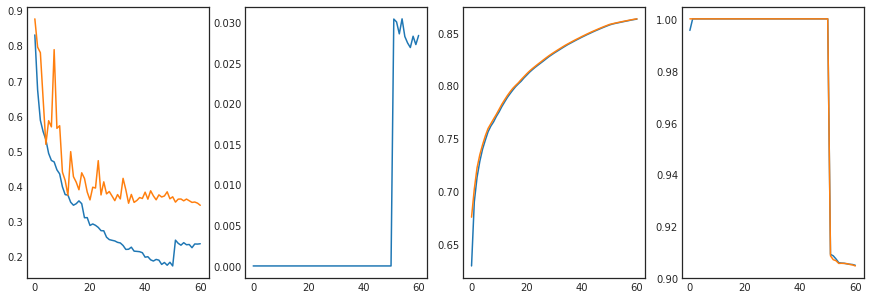

In [15]:
fig, (ax_loss, ax_temp_loss, ax_acc, ax_iou) = plt.subplots(1,4, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_temp_loss.plot(history.epoch, history.history["temperal_mse_loss"], label="Train loss")
# ax_temp_loss.plot(history.epoch, history.history["val_temperal_mse_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["mask_mean_iou"], label="Train mask iou")
ax_acc.plot(history.epoch, history.history["val_mask_mean_iou"], label="Validation mask iou")
ax_iou.plot(history.epoch, history.history["temperal_mean_iou"], label="Train temperal iou")
ax_iou.plot(history.epoch, history.history["val_temperal_mean_iou"], label="Validation temperal iou")

# Fine tune threshold

In [16]:
# model = load_model("./model-unet-resnet.h5", custom_objects={'mean_iou':mean_iou})

# # used for predict, no dropout
temperal = Temperal_Callback()
model_predict = UNet((img_size_target,img_size_target,1),start_ch=16,depth=5,batchnorm=True, dropout=0.0, training=False)
model_predict.compile(loss=temperal.temporal_loss, optimizer="adam", metrics=[masked_crossentropy, temperal_mse_loss, mask_mean_iou, temperal_mean_iou])
model_predict.set_weights(model_train.get_weights())

X_valid = np.expand_dims(np.stack((np.asarray(val_df['img'].values.tolist()))),axis=3)
y_valid = np.expand_dims(np.asarray(val_df['img_mask'].values.tolist()),axis=3)
preds_valid = model_predict.predict(X_valid, batch_size=32, verbose=1)

400/400 [==============================] - 1s 4ms/step


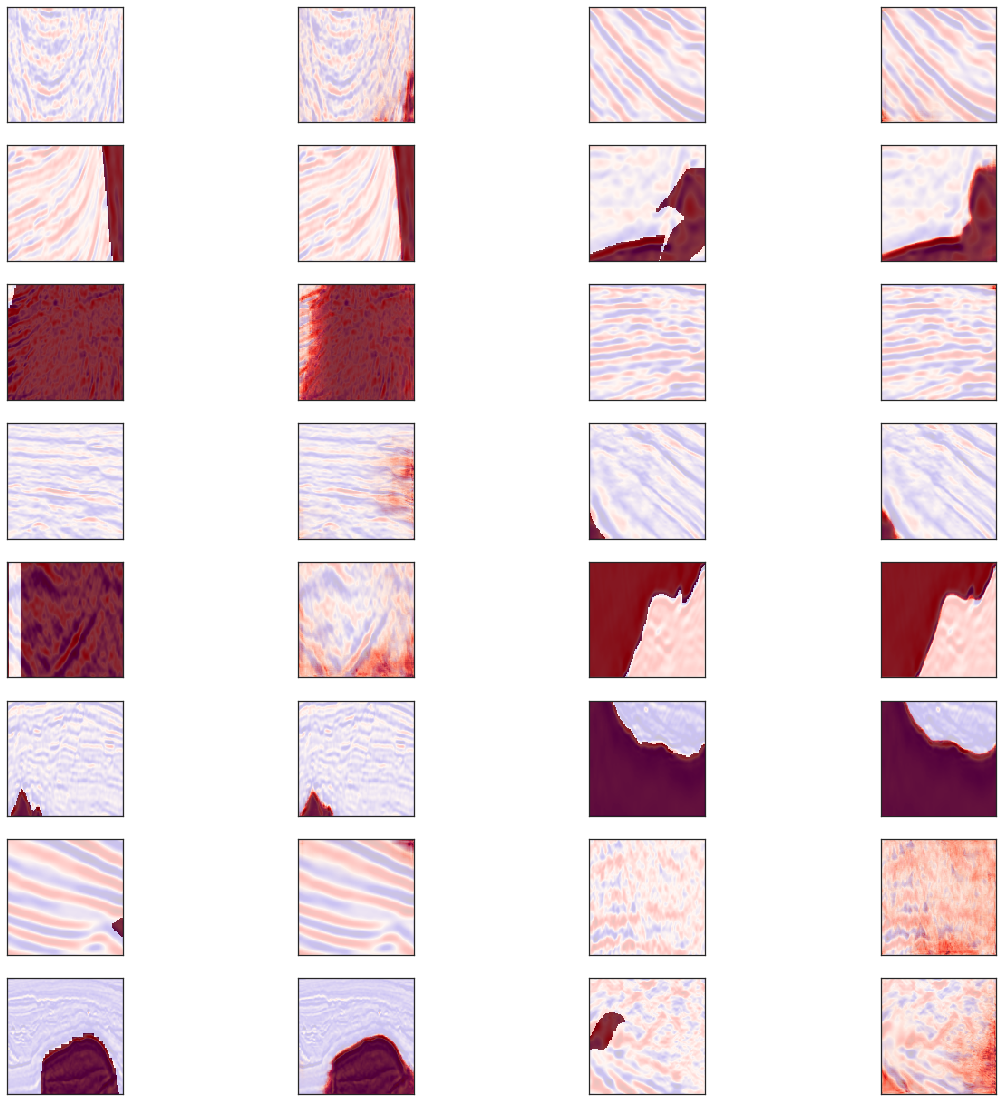

In [17]:
# plot some validate result
base_idx = 10
max_images = 32
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i, idx in enumerate(val_df.index[base_idx:base_idx+int(max_images/2)]):
    img = val_df.iloc[i].img
    mask = val_df.iloc[i].img_mask
    pred = preds_valid[i].squeeze()
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(mask, alpha=0.8, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(pred, alpha=0.8, cmap="Reds"); col+=1;
    ax.set_yticklabels([]);ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;


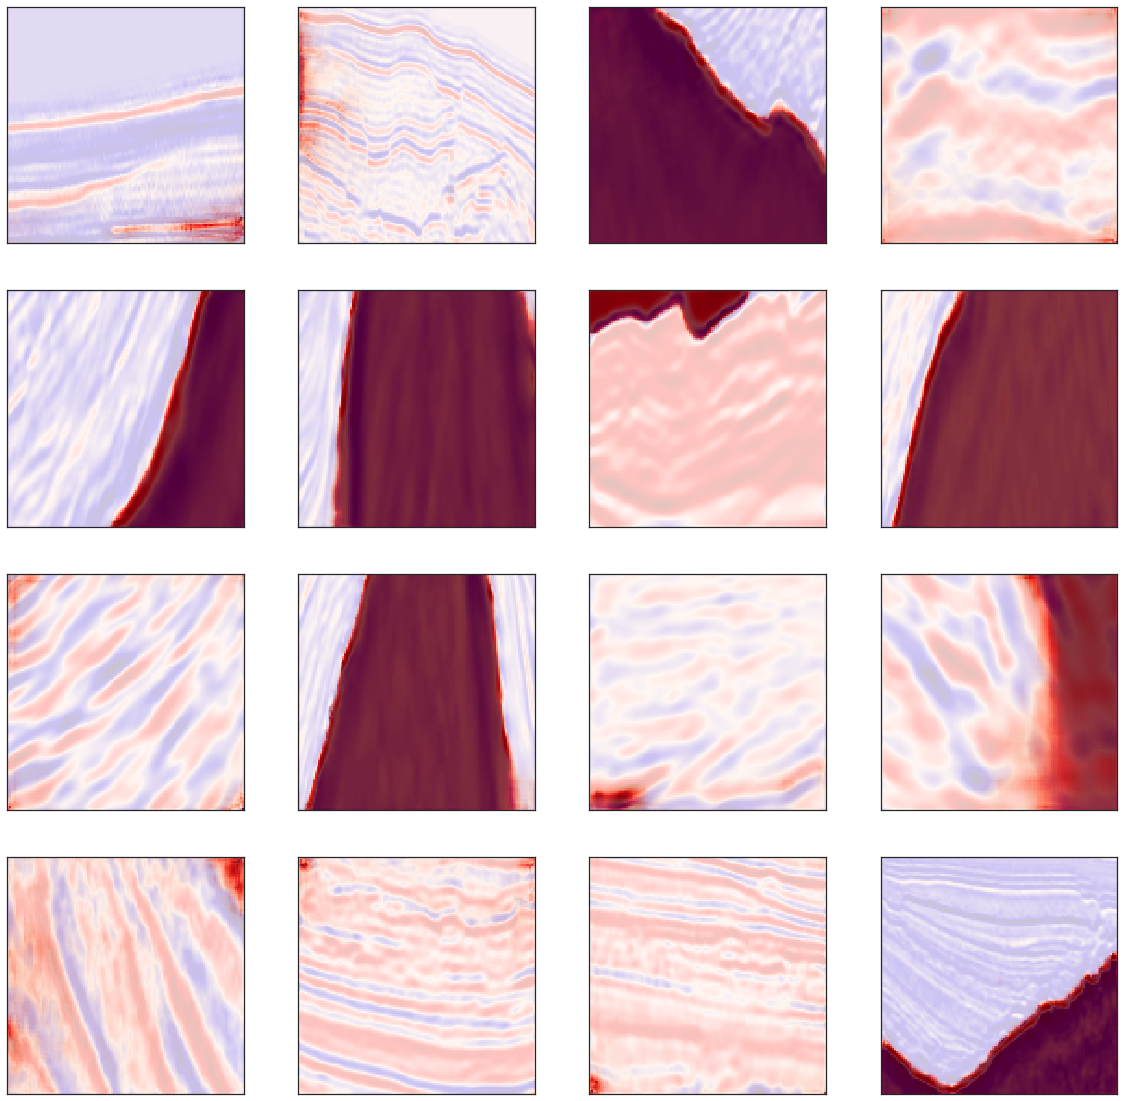

In [18]:
# plot some temperal mask on test results
base_idx = 0
max_images = 16
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i, idx in enumerate(test_df.index[base_idx:base_idx+int(max_images)]):
    img = test_df.loc[idx].img
    mask = test_df.loc[idx].img_temperal_mask
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
#     ax.imshow(img, cmap="gray")
    ax.imshow(mask, alpha=0.8, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;


In [19]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch],print_table=False)
        metric.append(value)
    return np.mean(metric)


from math import sqrt
from joblib import Parallel, delayed
import multiprocessing  
from tqdm import tqdm  

thresholds = np.linspace(0, 1, 20)
# result = Parallel(n_jobs=2)(io_metric_batch(train_y, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds))
# ious = np.array([iou_metric_batch(train_y, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])
ious = np.array([iou_metric_batch(y_valid, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

threshold_best: 0.8421052631578947, iou_best: 0.7827500000000001


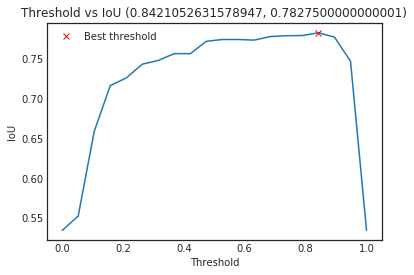

In [20]:
threshold_best_index = np.argmax(ious)
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

print(f'threshold_best: {threshold_best}, iou_best: {iou_best}')

plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

# Predict test data

In [21]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    #res = np.zeros((img_size_target, img_size_target), dtype=img.dtype)
    #res[:img_size_ori, :img_size_ori] = img
    #return res
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)
    #return img[:img_size_ori, :img_size_ori]
    
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [22]:
X_test = np.expand_dims(np.stack((np.asarray(test_df['img'].values.tolist()))),axis=3)
preds_test = model_predict.predict(X_test, batch_size=32, verbose=1)
final_preds_test = preds_test > threshold_best

3600/3600 [==============================] - 7s 2ms/step


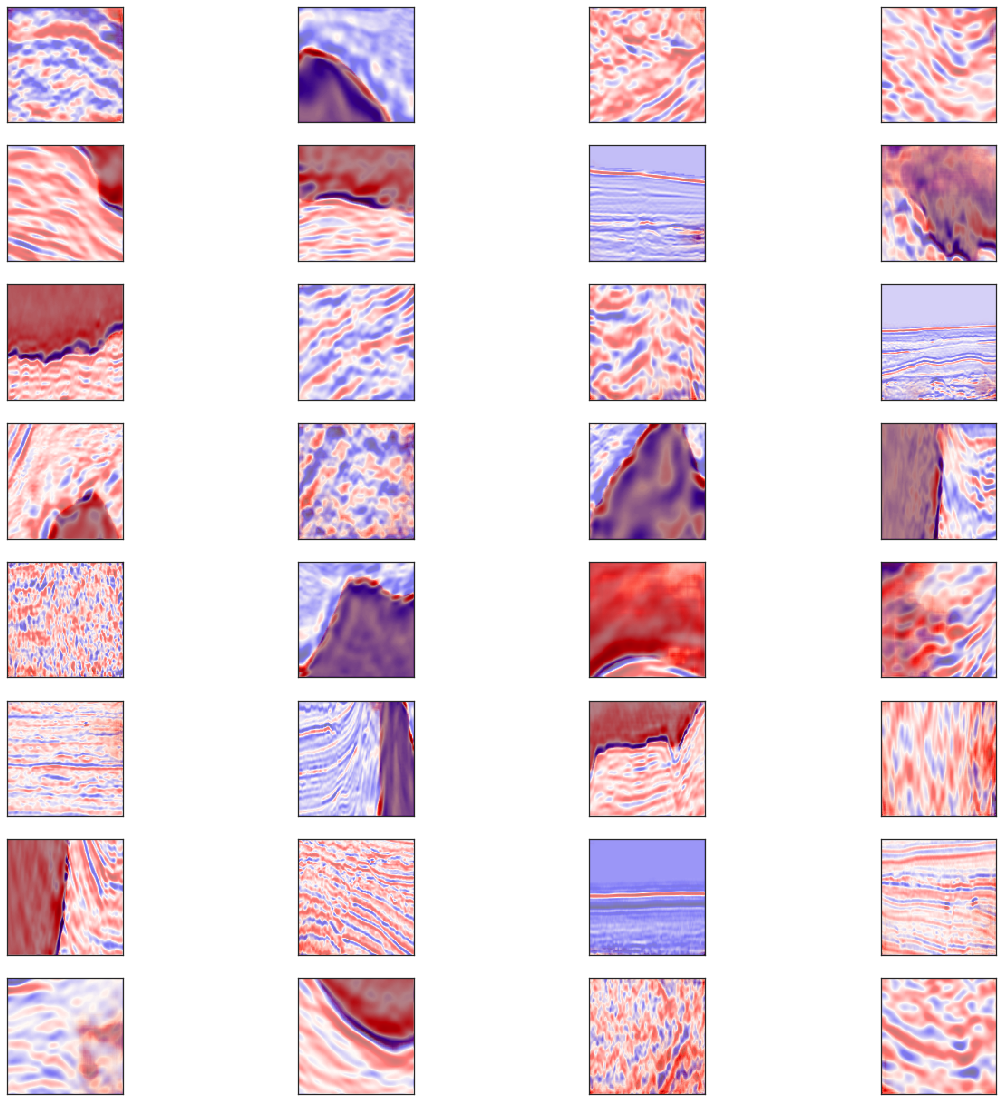

In [23]:
base_idx = 160
max_images = 32
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i in range(base_idx,base_idx+int(max_images)):
    img = X_test[i].squeeze()
    mask = preds_test[i].squeeze()
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(mask, alpha=0.5, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;

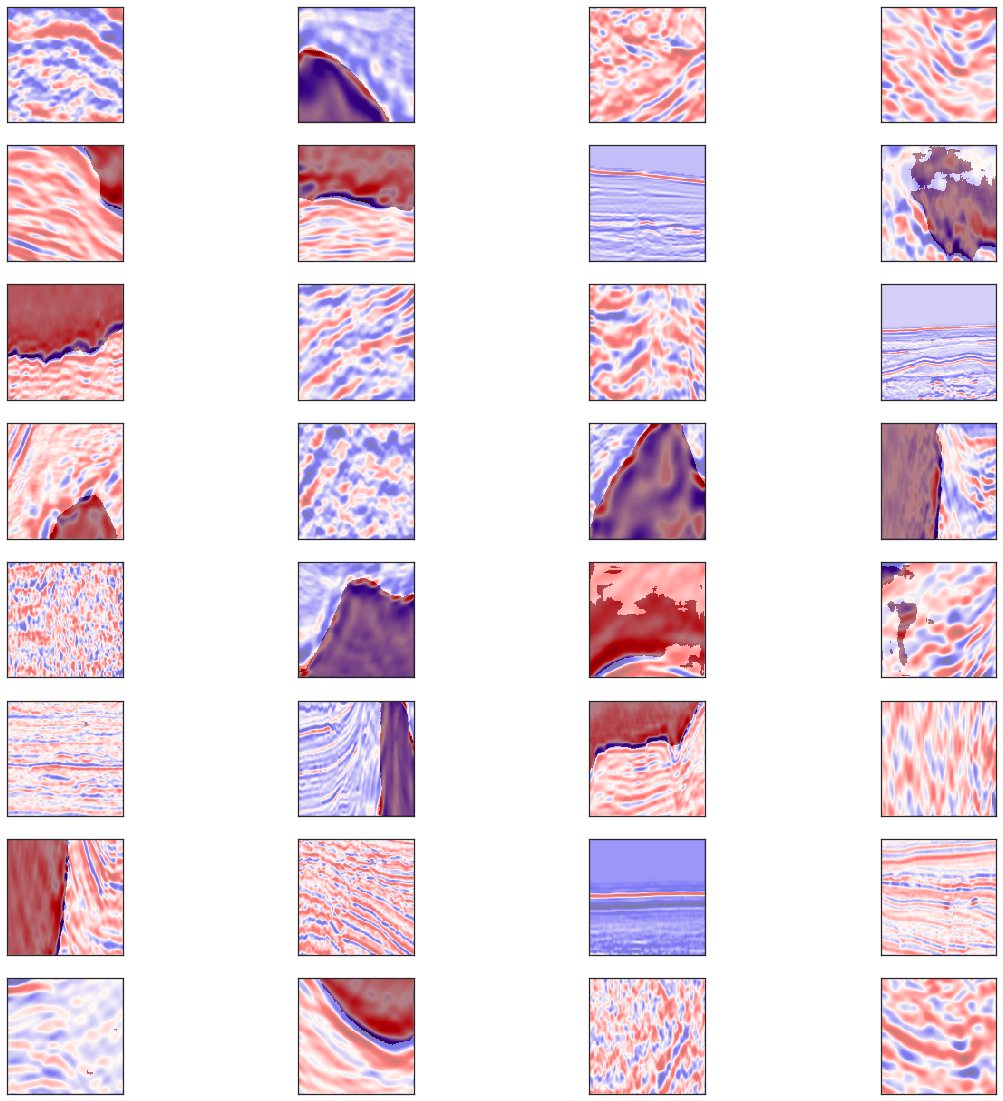

In [24]:
base_idx = 160
max_images = 32
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i in range(base_idx,base_idx+int(max_images)):
    img = X_test[i].squeeze()
    mask = final_preds_test[i].squeeze()
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(mask, alpha=0.5, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;

# Apply CRF

In [25]:
#Original_image = Image which has to labelled
#Mask image = Which has been labelled by some technique..
def crf(original_image, mask_img):
    
    # Converting annotated image to RGB if it is Gray scale
    if(len(mask_img.shape)<3):
        mask_img = gray2rgb(mask_img)

#     #Converting the annotations RGB color to single 32 bit integer
    annotated_label = mask_img[:,:,0] + (mask_img[:,:,1]<<8) + (mask_img[:,:,2]<<16)
    
#     # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_label, return_inverse=True)

    n_labels = 2
    
    #Setting up the CRF model
    d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

    # get unary potentials (neg log probability)
    U = unary_from_labels(labels, n_labels, gt_prob=0.7, zero_unsure=False)
    d.setUnaryEnergy(U)

    # This adds the color-independent term, features are the locations only.
    d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                      normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    #Run Inference for 10 steps 
    Q = d.inference(10)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    return MAP.reshape((original_image.shape[0],original_image.shape[1]))

In [26]:
"""
Applying CRF on the predicted mask 

"""
crf_output = []
for i in tqdm(range(X_test.shape[0])):
    crf_output.append(crf(np.squeeze(X_test[i]),np.squeeze(final_preds_test[i])))

100%|██████████| 3600/3600 [01:27<00:00, 41.34it/s]


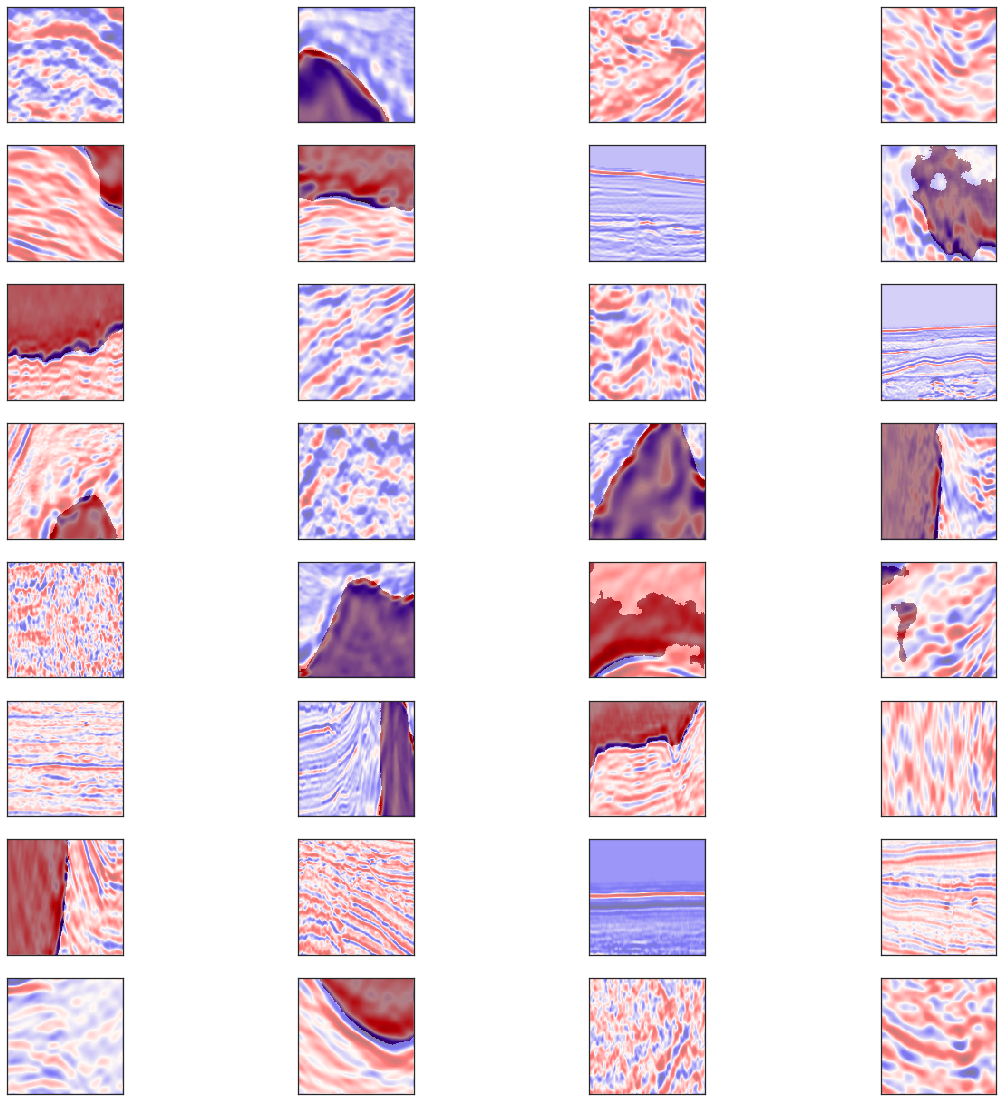

In [27]:
base_idx = 160
max_images = 32
grid_width = 4
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(20, 20))
row = 0; col = 0;
for i in range(base_idx,base_idx+int(max_images)):
    img = X_test[i].squeeze()
    mask = crf_output[i].squeeze()
    
    ax = axs[row, col];
    ax.imshow(img, cmap="seismic")
    ax.imshow(mask, alpha=0.5, cmap="Reds"); col+=1;
    ax.set_yticklabels([]); ax.set_xticklabels([]);
    
    if col >= grid_width:
        col=0; row+=1;

In [28]:
threshold_best=threshold_best
pred_dict = {idx: RLenc(np.round(downsample(crf_output[i]))) for i, idx in enumerate(tqdm_notebook(test_df.img_id.values))}
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission_pinet_crf.csv')